In [1]:
!pip install -q dask[dataframe]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_diabetes
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
# Load sample data
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Display the data
display(X.head())
print("\n")
display(y[:5])

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


array([151.,  75., 141., 206., 135.])

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Custom transformer to handle multiple models
class MultiModelEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, models):
        self.models = models
        self.fitted_models_ = {}

    def fit(self, X, y):
        for name, model in self.models.items():
            self.fitted_models_[name] = model.fit(X, y)
        return self

    def transform(self, X):
        predictions = {name: model.predict(X) for name, model in self.fitted_models_.items()}
        return pd.DataFrame(predictions, index=X.index)

In [6]:
# Custom pipeline class to abstract preprocessing and modeling
class CustomPipeline:
    def __init__(self, preprocessors, models):
        """
        Initializes the pipeline with preprocessing steps and models.

        Parameters:
            preprocessors (dict): Preprocessing transformers and parameters.
                Example: {'scaler': (StandardScaler, {}), 'poly': (PolynomialFeatures, {'degree': 2})}
            models (dict): Machine learning models to train and evaluate.
                Example: {'LinearRegression': LinearRegression(), 'RandomForest': RandomForestRegressor()}
        """
        self.preprocessors = preprocessors
        self.models = models
        self.pipeline = None

    def build_pipeline(self):
        """Builds the pipeline dynamically based on user-defined preprocessors and models."""
        preprocessor_steps = []

        # Build the preprocessing pipeline sequentially
        for name, (transformer_class, params) in self.preprocessors.items():
            preprocessor = transformer_class(**params)
            preprocessor_steps.append((name, preprocessor))

        # Create preprocessing pipeline and set pandas output
        preprocessor_pipeline = Pipeline(preprocessor_steps).set_output(transform="pandas")

        # Define the multi-model transformer step
        multi_model_step = MultiModelEstimator(self.models)

        # Build the full pipeline
        self.pipeline = Pipeline([
            ('preprocessing', preprocessor_pipeline),
            ('models', multi_model_step)
        ])

    def fit(self, X_train, y_train):
        """Fits the entire pipeline to training data."""
        self.build_pipeline()
        self.pipeline.fit(X_train, y_train)

    def predict(self, X_test):
        """Generates predictions from all models."""
        return self.pipeline.transform(X_test)

In [7]:
# Define preprocessing steps dynamically
preprocessing_steps = {
    'scaler': (StandardScaler, {}),
    'poly': (PolynomialFeatures, {'degree': 2, 'include_bias': False})
}

# Define models dynamically
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

In [8]:
# Instantiate the custom pipeline
custom_pipeline = CustomPipeline(preprocessing_steps, models)

# Fit the pipeline on training data
custom_pipeline.fit(X_train, y_train)

In [9]:
# Get predictions
predictions_df = custom_pipeline.predict(X_test)

# Display predictions
display(predictions_df.head())

,LinearRegression,RandomForest,XGBoost,LightGBM
287,116.399617,145.77,128.011246,139.552167
211,162.033168,167.07,155.590454,153.537589
72,175.486326,146.48,122.810097,137.805359
321,412.421041,247.85,184.791702,248.420800
73,98.856737,93.85,119.215027,99.482429


In [10]:
# Evaluate model performance
def evaluate_model_performance(y_true, predictions_df):
    """Evaluates model performance using RMSE, MAE, and R² scores."""
    metrics = {
        'RMSE': root_mean_squared_error,
        'MAE': mean_absolute_error,
        'R2': r2_score
    }

    results = {}

    for model_name in predictions_df.columns:
        results[model_name] = {metric_name: metric_func(y_true, predictions_df[model_name])
                               for metric_name, metric_func in metrics.items()}

    return pd.DataFrame(results).T

In [11]:
# Evaluate the test set predictions
performance_metrics_df = evaluate_model_performance(y_test, predictions_df)

# Display performance metrics
print("Model Performance Metrics:")
display(performance_metrics_df)

Model Performance Metrics:


,RMSE,MAE,R2
LinearRegression,55.641965,43.581693,0.415640
RandomForest,53.654600,44.721910,0.456638
XGBoost,60.211572,50.074870,0.315717
LightGBM,56.098301,45.075299,0.406016


In [12]:
# Multiply R2 by 100
performance_metrics_df['R2'] *= 100

# Rename 'R2' to 'R2 * 100'
performance_metrics_df.rename(columns={'R2': 'R2 * 100'}, inplace=True)

# Display the updated performance metrics
print("Updated Model Performance Metrics:")
display(performance_metrics_df)

Updated Model Performance Metrics:


,RMSE,MAE,R2 * 100
LinearRegression,55.641965,43.581693,41.563993
RandomForest,53.654600,44.721910,45.663767
XGBoost,60.211572,50.074870,31.571733
LightGBM,56.098301,45.075299,40.601562


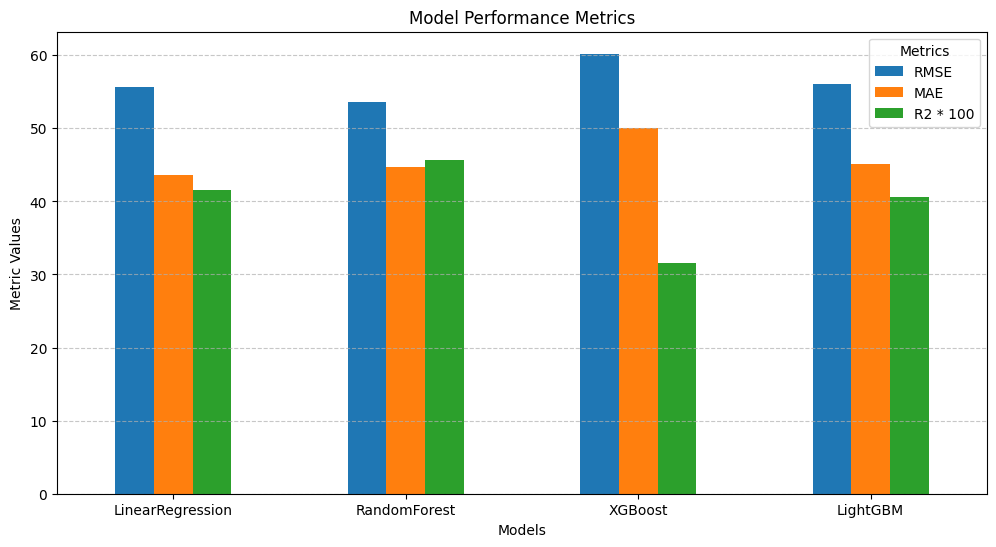

In [13]:
# Plot a grouped bar plot
ax = performance_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Metrics")
plt.xlabel("Models")
plt.ylabel("Metric Values")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()